In [59]:
import sys
# !{sys.executable} -m pip install jupyter ipywidgets -U
from glob import glob
import numpy as np
import joblib
import os
import pandas as pd
import json

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tqdm.notebook import tqdm
import seaborn as sns
 

In [2]:


gaussian_kernel = RBF()

models = {
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'knn': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    'grad': GradientBoostingRegressor(),
    'svr': SVR(),
    'krr': KernelRidge(),
    'gpr': GaussianProcessRegressor()
}

param_grid = {
    'ridge': {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 50, 100, 1000]
    },
    'knn': {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance']
    },
    'rfr': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'grad': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7]
    },
    'svr': {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.01, 0.001]
    },
    'krr': {
        'kernel': ['linear', 'poly', 'rbf'],
        'alpha': [0.001, 0.01, 0.1, 1],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'gpr': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': [gaussian_kernel]
    },
    'lasso': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    'elastic': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [1000, 2000, 3000]
    }
}


In [3]:
def gridsearch(model,X_tr, y_tr,X_tst,y_tst):
    """
    Perform GridSearchCV for a given model

    parameters
    ----------
    model: str
        Name of model

    X_tr: np.array
        X training

    y_tr: np.array
        Y Training

    X_tst: np.array
        X test

    y_tst: np.array
        y test

    Returns
    -------
    scores: dict
        scored models
    """
    st = time.time()
    current_model = models[model]
    current_param_grid = param_grid[model]

    grid_search = GridSearchCV(current_model, current_param_grid, cv=5,n_jobs=-1)

    print(f'Now fitting {model}... ')

    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_

    print(f'Completed fitting {model} in {time.time() - st} seconds. ')

    model=best_model
    scores = {}
    st = time.time()
    print('Now scoring model... ')
    y_tr_pred = model.predict(X_tr)
    y_tst_pred = model.predict(X_tst)
            
    scores['MSE_train'] = mean_squared_error(y_tr, y_tr_pred),
    scores['R2_train'] = r2_score(y_tr, y_tr_pred)
    scores['MAE_train'] = mean_absolute_error(y_tr, y_tr_pred)
    scores['MSE_test'] = mean_squared_error(y_tst, y_tst_pred)
    scores['R2_test'] = r2_score(y_tst, y_tst_pred)
    scores['MAE_test'] = mean_absolute_error(y_tst, y_tst_pred)

    return scores



In [4]:
# data=pd.read_csv(f'/Users/grierjones/qregress/function-calc-test/linear/linear.csv')
# x=data['x'].to_numpy().reshape(-1,1)
# y=data['y'].to_numpy().reshape(-1,1)
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8,test_size=20)


In [5]:
dirs=['quadratic','linear','sine']
trainsize=[0.3, 0.5, 0.7, 0.8, 0.1]

In [12]:
performance={}

for d in tqdm(dirs):
    data=pd.read_csv(f'/Users/grierjones/qregress/function-calc-test/{d}/{d}.csv')
    x=data['x'].to_numpy().reshape(-1,1)
    y=data['y'].to_numpy().reshape(-1,1)
    performance[d]={}
    for ts in tqdm(trainsize):
        X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=ts,test_size=20)
        train_name = os.path.join(d,'All',f"{ts}",f"{d}_train.bin")
        test_name = os.path.join(d,'All',f"{ts}",f"{d}_test.bin")
        print(train_name,test_name)
        train = {
            'X': X_train,
            'y': y_train
        }
        
        test = {
            'X': X_test,
            'y': y_test
        }
        
        
        joblib.dump(train, train_name)
        joblib.dump(test, test_name)
        performance[d][ts]={}
        for model in models.keys():
            scores=gridsearch(model,X_train, y_train,X_test,y_test)
            performance[d][ts][model]=scores
                
            with open(os.path.join(d,'All',f"{ts}",f'{model}_scores.json'), 'w') as outfile:
                json.dump(scores, outfile)
                print(f'Scores saved as {outfile.name}. ')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

quadratic/All/0.3/quadratic_train.bin quadratic/All/0.3/quadratic_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.05779314041137695 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.030604839324951172 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.27459025382995605 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/elastic_scores.json. 
Now fitting knn... 
Completed fitting knn in 0.025995969772338867 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.288930892944336 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4607119560241699 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.02771925926208496 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.05059504508972168 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.013675928115844727 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.3/gpr_scores.json. 
quadratic/All/0.5/quadratic_train.bin quadratic/All/0.5/quadratic_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.05765795707702637 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/ridge_scores.json. 
Now fitting lasso... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernel

Completed fitting lasso in 0.06897807121276855 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.0665273666381836 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/elastic_scores.json. 
Now fitting knn... 
Completed fitting knn in 0.046759843826293945 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2743630409240723 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4711489677429199 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.026334285736083984 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.04833817481994629 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.014571905136108398 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.5/gpr_scores.json. 
quadratic/All/0.7/quadratic_train.bin quadratic/All/0.7/quadratic_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.06470394134521484 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.05340886116027832 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/lasso_scores.json. 
Now fitting elastic... 
Completed fi

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2763888835906982 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/rfr_scores.json. 
Now fitting grad... 


1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

Completed fitting grad in 0.4797050952911377 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.024857282638549805 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.05720400810241699 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.05010485649108887 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.7/gpr_scores.json. 
quadratic/All/0.8/quadratic_train.bin quadratic/All/0.8/quadratic_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.07302999496459961 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.08731698989868164 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/lasso_scores.json. 
Now fitting elastic... 
Completed fit

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.3261749744415283 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.5094501972198486 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.026829004287719727 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.037687063217163086 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.0519559383392334 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.8/gpr_scores.json. 
quadratic/All/0.1/quadratic_train.bin quadratic/All/0.1/quadratic_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.055348873138427734 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.03312826156616211 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/lasso_scores.json. 
Now fitting elastic... 
Completed fi

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 848, in score
    y_pred = self.predict(X)
             ^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/neighbors/_regression.py", line 242, in predict
   

Completed fitting rfr in 1.2643101215362549 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4473998546600342 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.025083065032958984 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03700876235961914 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.013231039047241211 seconds. 
Now scoring model... 
Scores saved as quadratic/All/0.1/gpr_scores.json. 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

  0%|          | 0/5 [00:00<?, ?it/s]

linear/All/0.3/linear_train.bin linear/All/0.3/linear_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.07630228996276855 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.05608201026916504 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.0697789192199707 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/elastic_scores.json. 
Now fitting knn... 
Completed fitting knn in 0.04342174530029297 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2004868984222412 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/rfr_scores.json. 
Now fitting grad... 


e/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 

Completed fitting grad in 0.47877001762390137 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.05202889442443848 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03704094886779785 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.027323007583618164 seconds. 
Now scoring model... 
Scores saved as linear/All/0.3/gpr_scores.json. 
linear/All/0.5/linear_train.bin linear/All/0.5/linear_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.056138038635253906 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.04382514953613281 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.0709240436

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.1843149662017822 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4605679512023926 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.04675793647766113 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03689002990722656 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.01737213134765625 seconds. 
Now scoring model... 
Scores saved as linear/All/0.5/gpr_scores.json. 
linear/All/0.7/linear_train.bin linear/All/0.7/linear_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.051309823989868164 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.09930586814880371 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.098032712936

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2407801151275635 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4785139560699463 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.04108691215515137 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.048316001892089844 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.08424973487854004 seconds. 
Now scoring model... 
Scores saved as linear/All/0.7/gpr_scores.json. 
linear/All/0.8/linear_train.bin linear/All/0.8/linear_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.05765390396118164 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.08309316635131836 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.067517042160

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.3327951431274414 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.48368406295776367 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.048774003982543945 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.049536943435668945 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.08010387420654297 seconds. 
Now scoring model... 
Scores saved as linear/All/0.8/gpr_scores.json. 
linear/All/0.1/linear_train.bin linear/All/0.1/linear_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.031785011291503906 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.03707003593444824 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.160061836

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 848, in score
    y_pred = self.predict(X)
             ^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/neighbors/_regression.py", line 242, in predict
   

Completed fitting knn in 0.041925907135009766 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2048110961914062 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.44762587547302246 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.02567291259765625 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03609514236450195 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.027647972106933594 seconds. 
Now scoring model... 
Scores saved as linear/All/0.1/gpr_scores.json. 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vecto

  0%|          | 0/5 [00:00<?, ?it/s]

sine/All/0.3/sine_train.bin sine/All/0.3/sine_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.07109308242797852 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.03550291061401367 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.06859683990478516 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/elastic_scores.json. 
Now fitting knn... 
Completed fitting knn in 0.0882558822631836 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.1755568981170654 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.44932103157043457 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.026761293411254883 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03803610801696777 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.01442718505859375 seconds. 
Now scoring model... 
Scores saved as sine/All/0.3/gpr_scores.json. 
sine/All/0.5/sine_train.bin sine/All/0.5/sine_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.05801796913146973 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.042382001876831055 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.07282400131225586 seconds. 
No

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2496497631072998 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4908406734466553 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.02736687660217285 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03744196891784668 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.015295982360839844 seconds. 
Now scoring model... 
Scores saved as sine/All/0.5/gpr_scores.json. 
sine/All/0.7/sine_train.bin sine/All/0.7/sine_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.06785273551940918 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.03480124473571777 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.07004475593566895 seconds. 
Now 

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.2530732154846191 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4745819568634033 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.026620149612426758 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03583574295043945 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.055928707122802734 seconds. 
Now scoring model... 
Scores saved as sine/All/0.7/gpr_scores.json. 
sine/All/0.8/sine_train.bin sine/All/0.8/sine_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.04956412315368652 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/ridge_scores.json. 
Now fitting lasso... 


  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Completed fitting lasso in 0.05578804016113281 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.06952691078186035 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/elastic_scores.json. 
Now fitting knn... 
Completed fitting knn in 0.05333995819091797 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/knn_scores.json. 
Now fitting rfr... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

Completed fitting rfr in 1.252242088317871 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/rfr_scores.json. 
Now fitting grad... 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensembl

Completed fitting grad in 0.4997439384460449 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.027817964553833008 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.03831195831298828 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.05219411849975586 seconds. 
Now scoring model... 
Scores saved as sine/All/0.8/gpr_scores.json. 
sine/All/0.1/sine_train.bin sine/All/0.1/sine_test.bin
Now fitting ridge... 
Completed fitting ridge in 0.052124977111816406 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/ridge_scores.json. 
Now fitting lasso... 
Completed fitting lasso in 0.06816220283508301 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/lasso_scores.json. 
Now fitting elastic... 
Completed fitting elastic in 0.0695350170135498 seconds. 
Now 

/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 848, in score
    y_pred = self.predict(X)
             ^^^^^^^^^^^^^^^
  File "/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/neighbors/_regression.py", line 242, in predict
   

Completed fitting rfr in 1.342738151550293 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/rfr_scores.json. 
Now fitting grad... 


1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

Completed fitting grad in 0.44382214546203613 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/grad_scores.json. 
Now fitting svr... 
Completed fitting svr in 0.027307748794555664 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/svr_scores.json. 
Now fitting krr... 
Completed fitting krr in 0.04654717445373535 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/krr_scores.json. 
Now fitting gpr... 
Completed fitting gpr in 0.013452768325805664 seconds. 
Now scoring model... 
Scores saved as sine/All/0.1/gpr_scores.json. 


/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/grierjones/miniconda3/lib/python3.12/site-packag

In [107]:
for k,v in performance['quadratic'].items():
    # print(k,v)
    for k1,v1 in v.items():
        print(k,k1,v1['R2_train'],v1['R2_test'],v1['R2_train']-v1['R2_test'])

0.3 ridge 0.0004671882248826753 -0.056440929676381035 0.05690811790126371
0.3 lasso 0.0 -0.05538691922258998 0.05538691922258998
0.3 elastic 0.0 -0.05538691922258998 0.05538691922258998
0.3 knn 1.0 0.8985976215051006 0.10140237849489941
0.3 rfr 0.992937175191044 0.8951978678735943 0.09773930731744962
0.3 grad 0.9817342893538655 0.87326275284013 0.10847153651373553
0.3 svr 0.9934008835656617 0.9697086635651264 0.02369222000053528
0.3 krr 0.9955273843009068 0.9941941142028594 0.001333270098047401
0.3 gpr 0.996440050138288 0.8765630319266573 0.11987701821163066
0.5 ridge 0.011281193728482908 -0.10442027341689131 0.11570146714537421
0.5 lasso 0.012134737830490128 -0.14082861521876988 0.15296335304926
0.5 elastic 0.012081311791180771 -0.1316897959557648 0.14377110774694557
0.5 knn 1.0 0.9866373947399583 0.013362605260041738
0.5 rfr 0.9975119151814823 0.9782042188756042 0.01930769630587814
0.5 grad 0.9999470292194056 0.9745120650773549 0.02543496414205071
0.5 svr 0.9948716943466418 0.9873589

In [108]:
def save_bar(name):
    meltdef=[]
    for k,v in performance[name].items():
        for k1,v1 in v.items():
            for k2,v2 in v1.items():
                if "R2" in k2:
                    meltdef.append((k,k1,k2,v2))
                    
    df=pd.DataFrame(meltdef,columns=['Train','Model','Metric','Score'])
    
    g=sns.catplot(
        df, kind="bar",
        x="Train", y="Score", col="Model", hue='Metric',
        height=4, aspect=1, col_wrap=5,palette=sns.color_palette("Paired",2)
    )
    g.set_axis_labels("Training Set Ratio", "R$^{2}$")
    g.set_titles("{col_var}={col_name}")
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    # plt.title(f"{name}")
    plt.tight_layout()
    plt.savefig(f'{name}.png',dpi=300,bbox_inches='tight')
    plt.show()

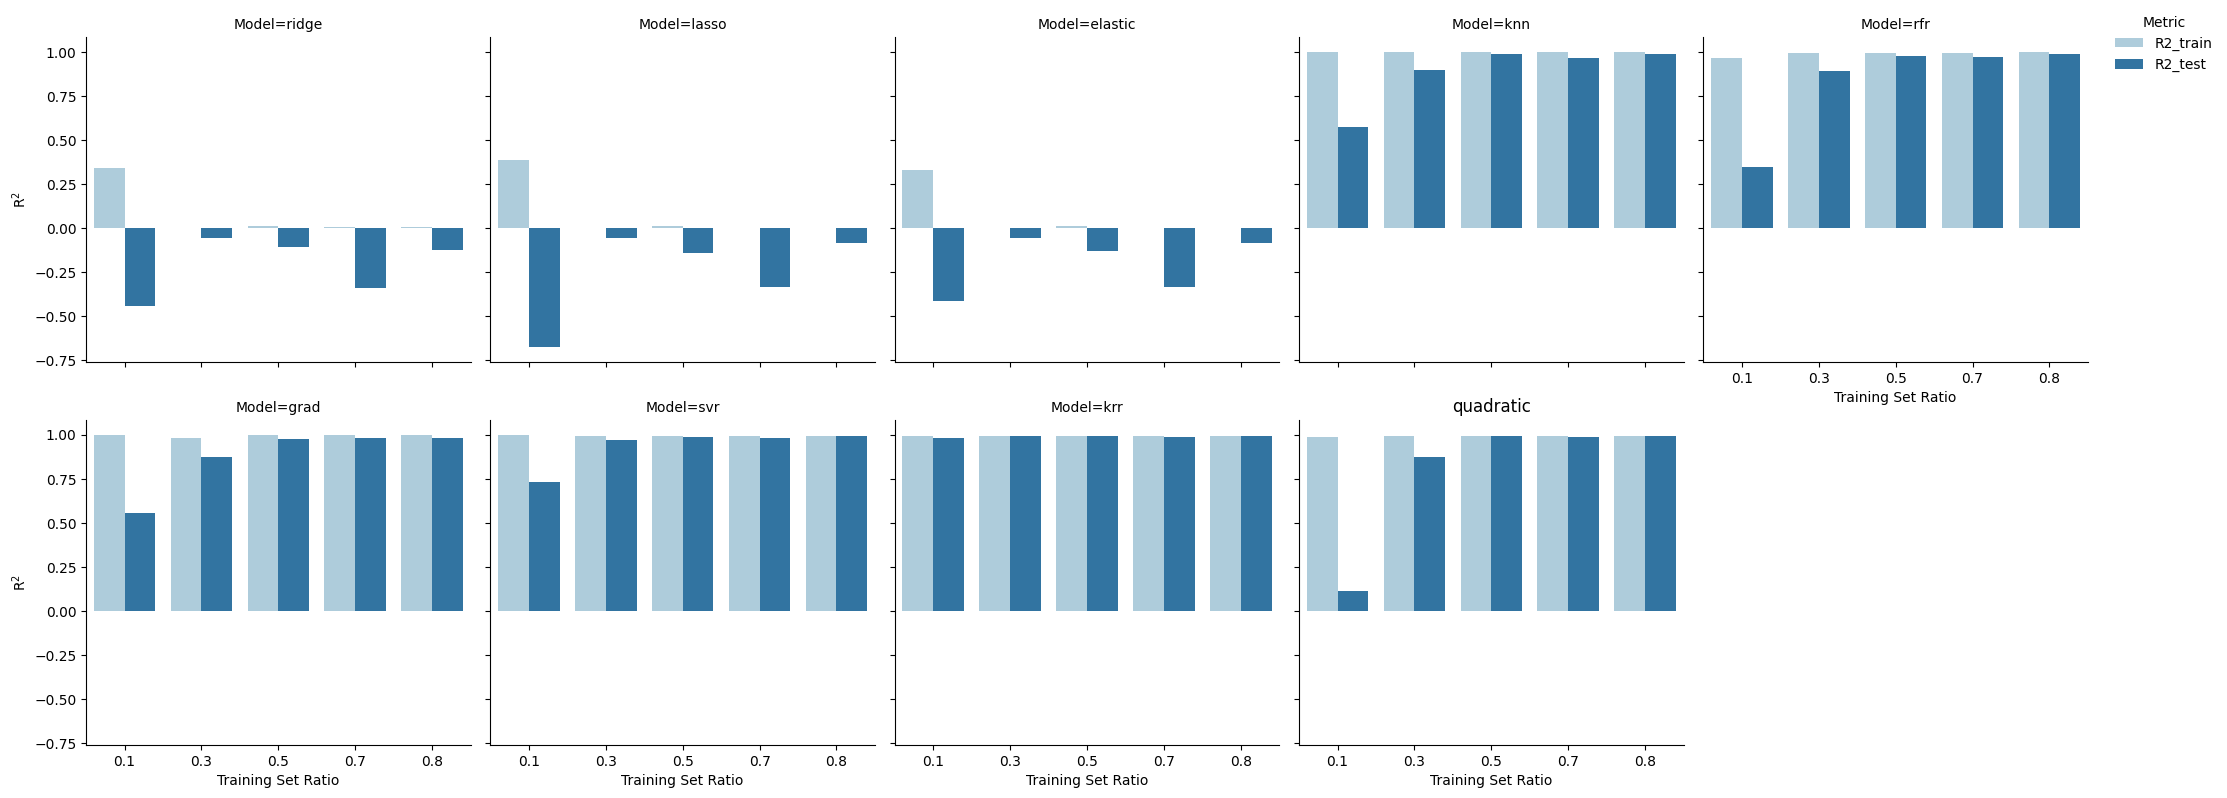

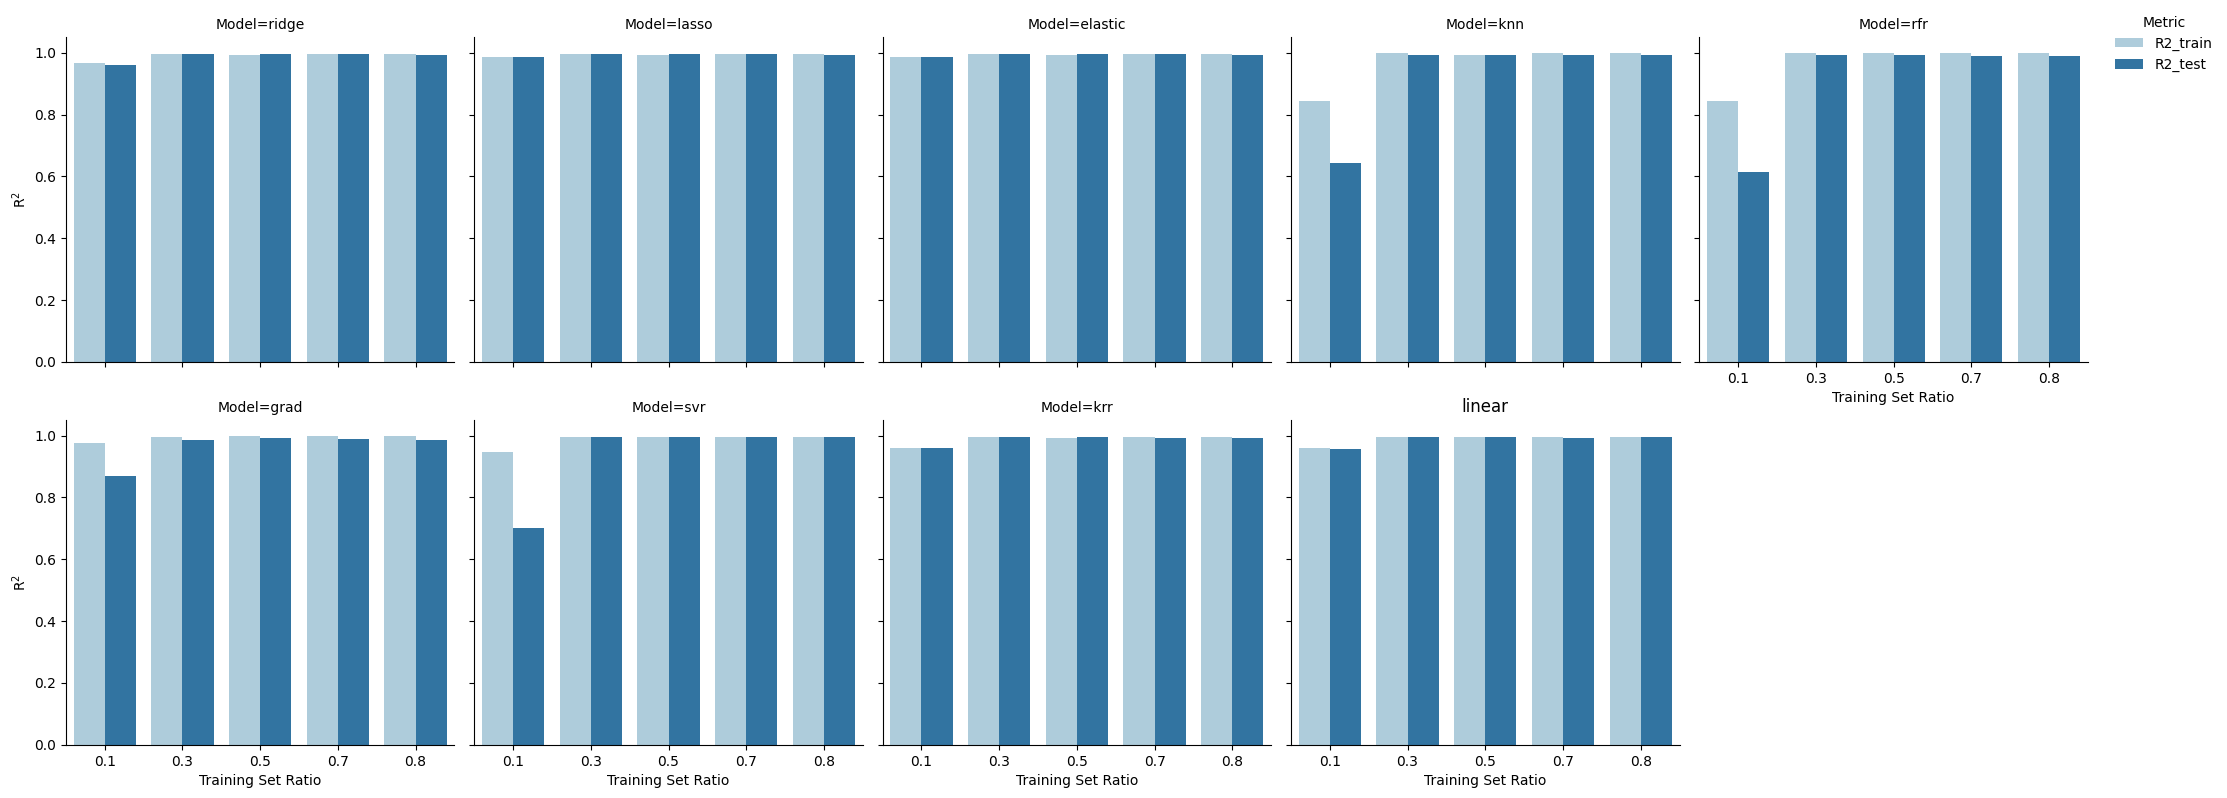

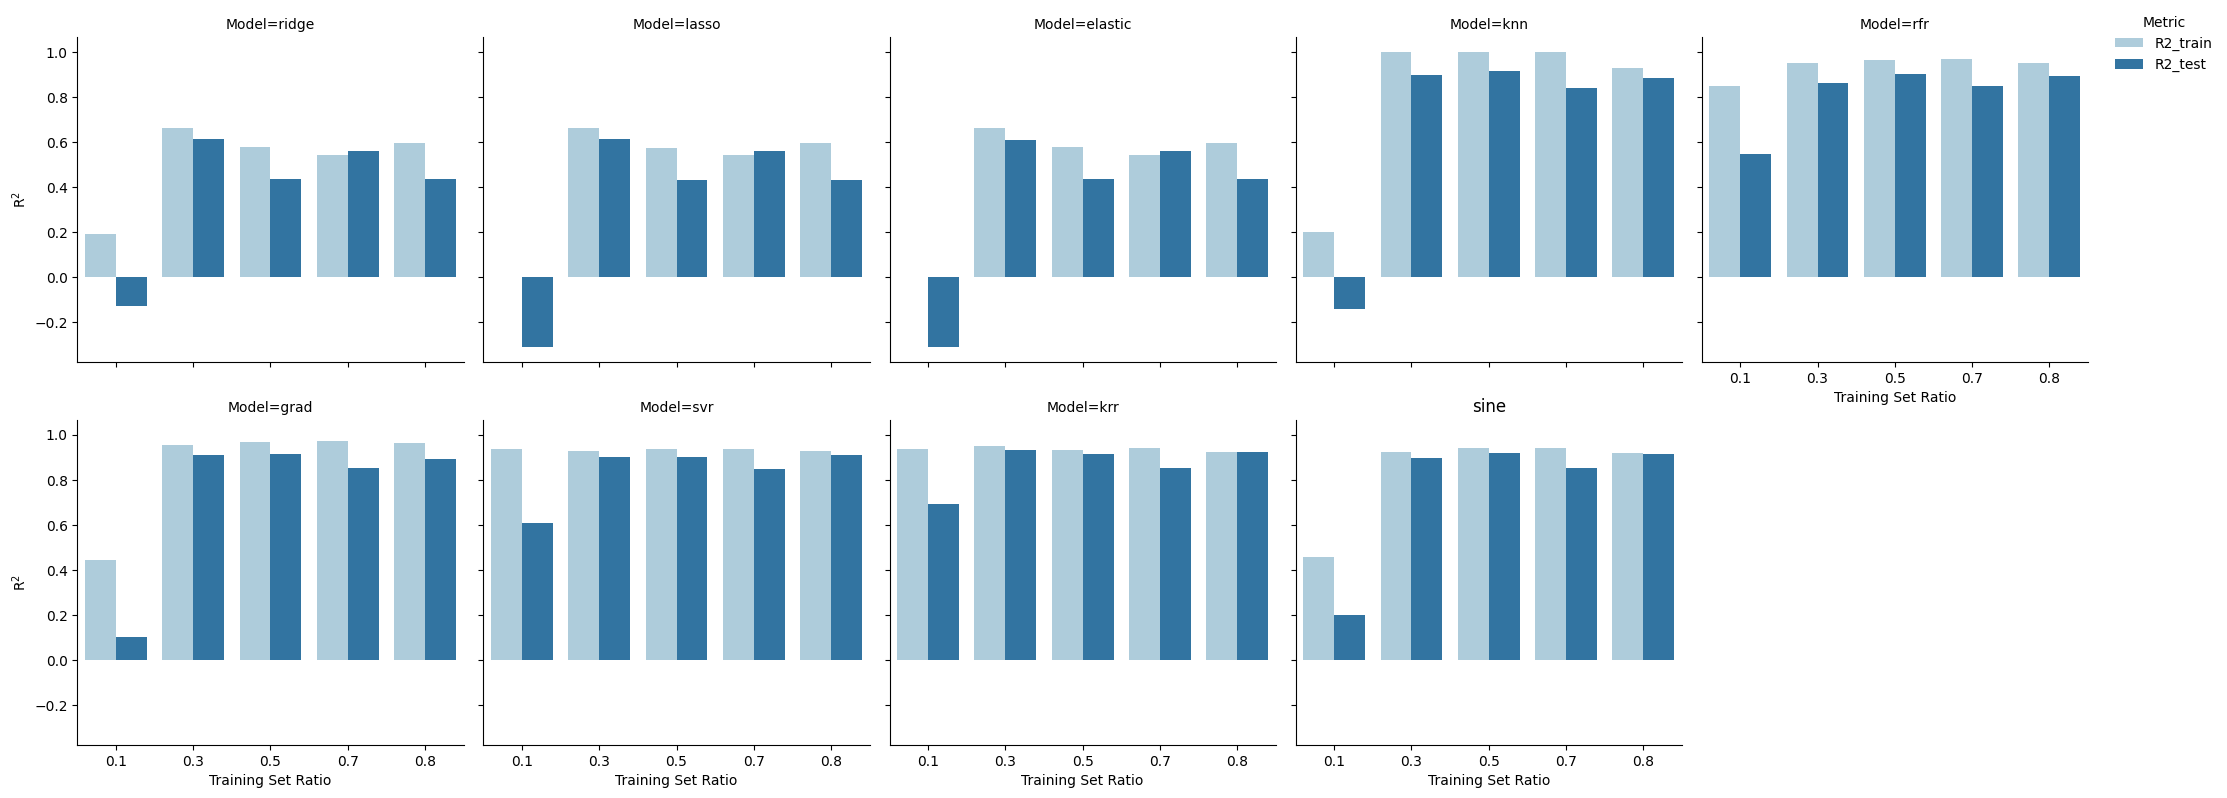

In [109]:
for i in dirs: 
    save_bar(i)